In [103]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate, linalg, optimize
import statistics
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [104]:
def closest(lst, K):
      
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return lst[idx]
     
def counts_to_irradiance(flame_data, integration_time, k_filepath):
    
    k_data = np.loadtxt(k_filepath,skiprows=1)
    irradiance = np.zeros(flame_data.shape)
    for i in range(len(irradiance[:,0])):
        irradiance[i,0] = flame_data[i,0]
        k_data_closest_index = np.where(k_data[:,0] == closest(k_data[:,0],flame_data[i,0]))[0]
        irradiance[i,1] = flame_data[i,1]*k_data[k_data_closest_index[0],1]/integration_time
        
    return irradiance

In [167]:
txt_filelist = os.listdir(os.path.join(os.getcwd(),'Red Sweep Opening'))
int_time = 0.0001*2
k_filepath = 'flame_to_irradiance_calibrationfile.txt'
spectra_data = None
bg_spectra = np.loadtxt(os.path.join('Red Sweep Opening',txt_filelist[0]), skiprows=1)

for i in range(0,100):
    load_spectra = np.loadtxt(os.path.join('Red Sweep Opening',txt_filelist[i]), skiprows=1)
    actual_txt_spectra = np.zeros(load_spectra.shape)
    actual_txt_spectra [:,0] = load_spectra[:,0]
    actual_txt_spectra [:,1] = load_spectra[:,1] - bg_spectra[:,1]
    actual_irradiance_spectra = counts_to_irradiance(actual_txt_spectra,int_time,k_filepath)
    if i == 0:
        spectra_data = actual_irradiance_spectra
    else:
        spectra_data = np.dstack((spectra_data, actual_irradiance_spectra))

cut_wl_relation = np.loadtxt(os.path.join('Red Sweep Opening','Red Sweep Opneing - cutting wavelenght relation.txt'), skiprows=1)

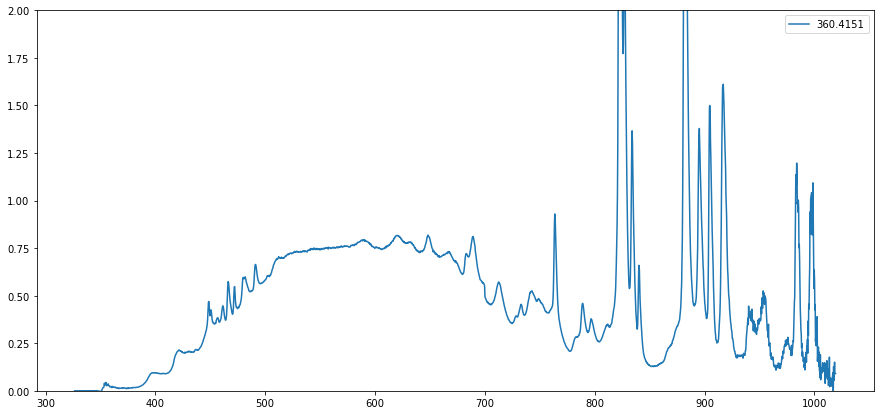

In [168]:
j = 99

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(spectra_data[:,0,j], spectra_data[:,1,j], label=str(cut_wl_relation[j,2]))
plt.ylim(0,2)
ax.legend()


In [176]:
#We load the measurements:

measurement_data= np.loadtxt('MCV.210604.OF2..Red Sweep Opening.txt', skiprows=1)
#measurement_data= np.loadtxt('MCV.210602.OT2m2.recalibrated..Red Sweep Opening.txt', skiprows=1)

measure_Jsc = -1*measurement_data[:,2]

for i in range(len(measure_Jsc)):
    measure_Jsc[i] = measure_Jsc[i]-measure_Jsc[0]



measure_divwl = measurement_data[:,0]
min_cutwl = np.min(measure_divwl)
max_cutwl = np.max(measure_divwl)
inc_cutwl = abs(min_cutwl-max_cutwl)/(len(measure_divwl)-1)



In [170]:

spectra_matrix = None
spectra_matrix_wls = spectra_data[:,0,0]
for i in range(len(measure_divwl)):
    actual_cutwl = measure_divwl[i]
    actual_spectra_data_index_cutwl = np.where(cut_wl_relation[:,2] == closest(cut_wl_relation[:,2], actual_cutwl))[0]
    actual_cut_wl_spectra = np.transpose(spectra_data[:,1,actual_spectra_data_index_cutwl[0]])
    #print([actual_cut_wl, cut_wl_relation[actual_spectra_data_index_cutwl[0],2]])
    actual_spectra_matrix_cut_wl = cut_wl_relation[actual_spectra_data_index_cutwl[0],2]
    if i == 0:
        spectra_matrix_cutwl = actual_spectra_matrix_cut_wl
        spectra_matrix_cutwl_ideal = actual_cutwl
        spectra_matrix = actual_cut_wl_spectra
    else:
        spectra_matrix_cutwl = np.vstack((spectra_matrix_cutwl, actual_spectra_matrix_cut_wl))
        spectra_matrix_cutwl_ideal = np.vstack((spectra_matrix_cutwl_ideal, actual_cutwl))
        spectra_matrix = np.vstack((spectra_matrix, actual_cut_wl_spectra))

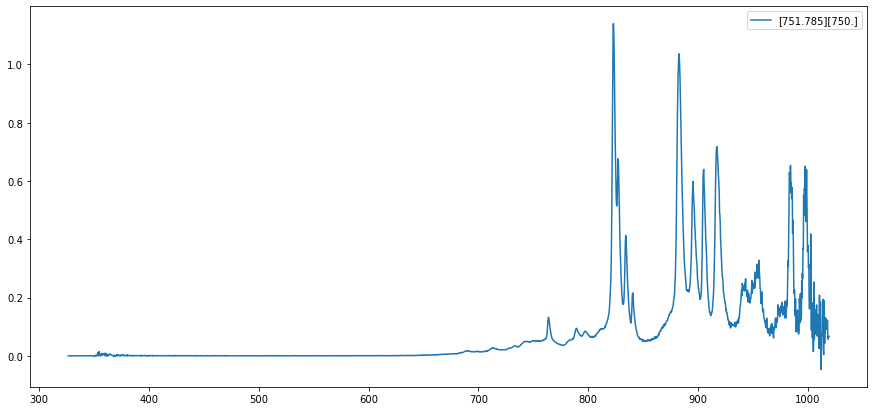

In [134]:
j = 1
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(spectra_matrix_wls, spectra_matrix[j,:], label=str(spectra_matrix_cutwl[j])+str(spectra_matrix_cutwl_ideal[j]))
ax.legend()

In [171]:
#Now we construct the c matrix

c_matrix = np.zeros((len(spectra_matrix_cutwl_ideal),len(spectra_matrix_cutwl_ideal)))
ideal_max = int(np.max(spectra_matrix_cutwl_ideal))
ideal_min = int(np.min(spectra_matrix_cutwl_ideal))
mintomax_wl_distrib = np.linspace(ideal_min-inc_cutwl/2, ideal_max+inc_cutwl/2, ideal_max-ideal_min+int(inc_cutwl)+1)
#print(mintomax_wl_distrib)
for i in range(len(c_matrix[:,0])):
    actual_spectra_interpolation = interpolate.interp1d(spectra_matrix_wls, spectra_matrix[i,:], kind='cubic')
    iteration_wl = spectra_matrix_cutwl
    
    for j in range(len(c_matrix[0,:])):
        actual_spectra_average = statistics.mean(actual_spectra_interpolation(mintomax_wl_distrib[10*j:10*(j+1)]))
        c_matrix[i,j] = 0.1*inc_cutwl*actual_spectra_average/1240*spectra_matrix_cutwl_ideal[j]
        if abs(c_matrix[i,j]) <= 0.02:
            c_matrix[i,j] = 0

c_matrix = np.flip(c_matrix, axis=1)


        

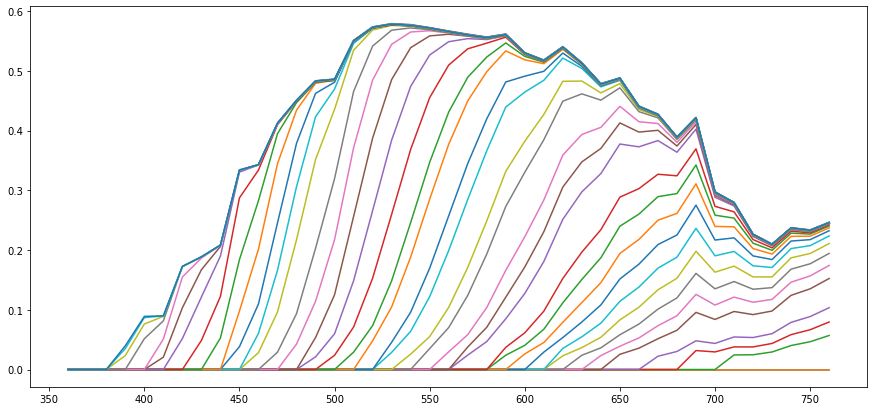

In [154]:
#c_matrix[:,-1:-3] =
fig, ax = plt.subplots(figsize=(15,7))
for j in range(0,41):
    
    #ax.plot(spectra_matrix_wls, spectra_matrix[j,:], label=str(spectra_matrix_cutwl[j])+str(spectra_matrix_cutwl_ideal[j]))
    ax.plot(spectra_matrix_cutwl_ideal[:],c_matrix[j,:], label=str(j))
    #ax.legend()


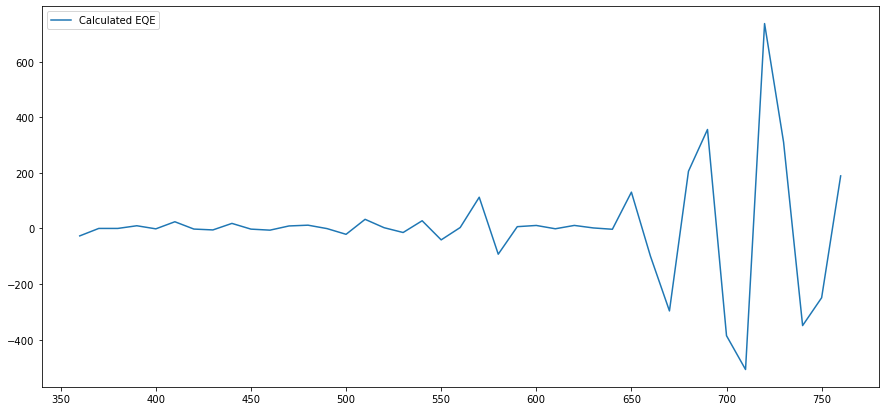

In [146]:
#Here we do the calculations with the linear equations system

EQE_linearsolution, residuals, rank, s = np.linalg.lstsq(c_matrix, measure_Jsc, rcond=None)
#EQE_linearsolution = linalg.solve(c_matrix, measure_Jsc)
fig, ax = plt.subplots(figsize=(15,7))

#print(EQE_linearsolution)
#ax.plot(sf.Extract_Column(Active_layer_1.EQE_curve, 0), 1*np.array(sf.Extract_Column(Active_layer_1.EQE_curve, 1)), label = 'Real EQE')
ax.plot(measure_divwl, EQE_linearsolution, label = 'Calculated EQE')
#ax.plot(spectra_data[:,0,20],spectra_data[:,1,99])
ax.legend()
#plt.ylim(-100,100)
#plt.xlim(350,740)
plt.figsize=(8, 6)


In [116]:
invA = np.linalg.inv(c_matrix)
EQE_linearsolution = np.dot(invA,measure_Jsc)

fig, ax = plt.subplots(figsize=(15,7))


ax.plot(measure_divwl, 0.1*EQE_linearsolution, label = 'Calculated EQE')
ax.legend()
#plt.ylim(-100,100)
#plt.xlim(350,740)
plt.figsize=(8, 6)

LinAlgError: Singular matrix

In [ ]:
for j in range(len(c_matrix[:,0])):
    summ = 0
    for i in range(len(c_matrix[j,:])):
        summ=summ+c_matrix[j,i]*EQE_linearsolution[i]

    print(summ, measure_Jsc[j])

<ipython-input-172-27d3744adf66>:7: RuntimeWarning: divide by zero encountered in double_scalars
  actual_EQE = (measure_Jsc[i+1]-measure_Jsc[i])/inc_cutwl/c_matrix[-1,i]


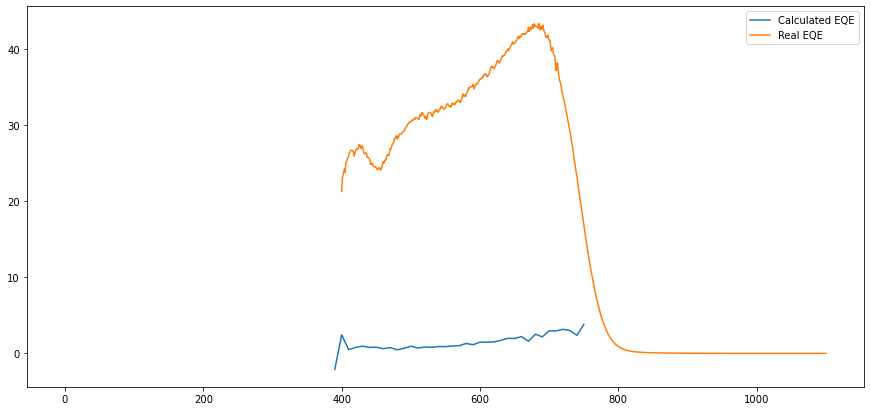

In [172]:
#Try to get a first aproximation of the EQE with the step function idea
EQE_aproximation = np.zeros((len(c_matrix[0,:]), 2))
#flip_c_matrix = np.flip(c_matrix, axis=0)

for i in range(len(c_matrix[0,:])-1):
    EQE_aproximation[i,0] = measure_divwl[i]
    actual_EQE = (measure_Jsc[i+1]-measure_Jsc[i])/inc_cutwl/c_matrix[-1,i]
    EQE_aproximation[i,1] = actual_EQE
    



real_EQE= np.loadtxt('MCV.210602.OT2.labona.L.04.txt', skiprows=1)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(EQE_aproximation[:,0], EQE_aproximation[:,1], label = 'Calculated EQE')
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
ax.legend()
#plt.ylim(-100,100)
#plt.xlim(350,740)
plt.figsize=(8, 6)

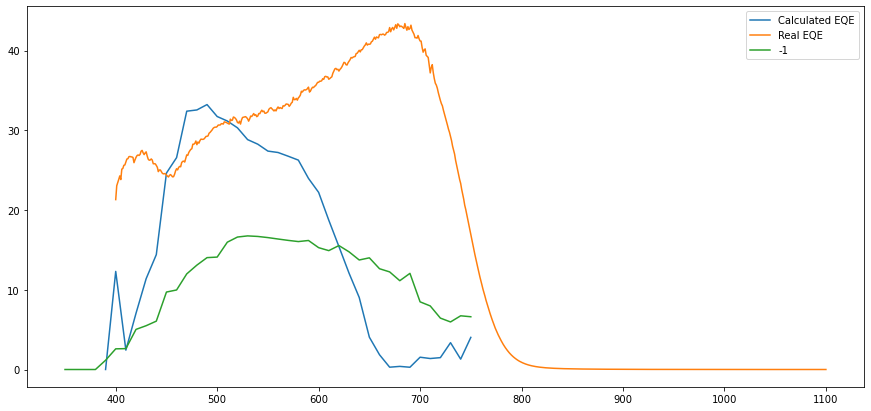

In [177]:
def EQE_minimize(EQE_solution,A,b):    
    AEQE_product = np.dot(A,EQE_solution)
    EQE_minimize = abs(AEQE_product[:]-b[:])
    
    return np.sum(EQE_minimize[0:35])

bnds = optimize.Bounds(0, 100)
EQE_approximation = np.ones(EQE_aproximation.shape)
EQE_approximation[:,1] = 50*EQE_approximation[:,1]
EQE_minimize_solution = optimize.minimize(EQE_minimize, EQE_aproximation[:,1], args = (c_matrix, measure_Jsc),bounds=bnds )
#print(EQE_minimize_solution)

fig, ax = plt.subplots(figsize=(15,7))
EQE_aproximation[-1,0] = 350
ax.plot(EQE_aproximation[0:-4,0], 5*EQE_minimize_solution.x[0:-4], label = 'Calculated EQE')
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
j=-1
ax.plot(spectra_matrix_cutwl_ideal[:],50*c_matrix[j,:], label=str(j))
ax.legend()
#plt.ylim(0,100)
#plt.xlim(350,740)
plt.figsize=(8, 6)


In [166]:
for j in range(len(c_matrix[:,0])):
    summ = 0
    for i in range(len(c_matrix[j,:])):
        summ=summ+c_matrix[j,i]*EQE_minimize_solution.x[i]

    print(summ, measure_Jsc[j])

0.0 0.0
3.2361020809429384 5.047541
5.93364095243048 8.248844
9.080938804688081 11.831187
16.471607542259303 15.919272
20.79163215713826 20.640956
25.666693704320913 25.666692
30.739885770314586 30.902858
35.8190646540599 36.534614
41.10891201948992 40.444464
46.17502457070275 46.022519
51.022179493395285 51.535914
55.56108709260664 56.988024
63.605892058179414 62.06858
66.89194457070755 66.747238
70.11131847226162 71.148683
75.66691794917273 75.666918
78.42184498602914 79.366573
83.55926405363029 83.559536
85.88941483796692 86.881597
90.35502089732718 90.072941
92.49071476687918 93.016182
96.02507388216996 96.021927
99.0030822522605 98.714969
101.45595906696214 101.45596
103.5368383500059 103.719709
105.45004348141744 106.384453
108.26104240428452 108.2599
109.82381494342877 109.503854
111.24552117618508 111.323668
112.8064345070582 112.571582
113.97419631315353 114.158213
115.19629468370404 115.113023
116.16066208796546 116.160738
116.61639560920412 116.940205
116.5622623219465 117.1